In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
from glob import glob
from scipy import misc
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [3]:
data = glob('data2/figs_*/*.png')

In [4]:
len(data)

4000

In [5]:
data[:2]

['data2\\figs_0\\f0001_01.png', 'data2\\figs_0\\f0002_05.png']

In [6]:
images = []
def read_images(data):
    for i in range(len(data)):
        img = misc.imread(data[i])
        img = misc.imresize(img,(224,224))
        images.append(img)
    return images

In [7]:
images = read_images(data)

C:\Users\pranay\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
C:\Users\pranay\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


In [8]:
images[0].shape

(224, 224)

In [9]:
images[0].dtype

dtype('uint8')

In [10]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
images_arr[0].dtype

dtype('float32')

In [11]:
images_arr.shape

(4000, 224, 224)

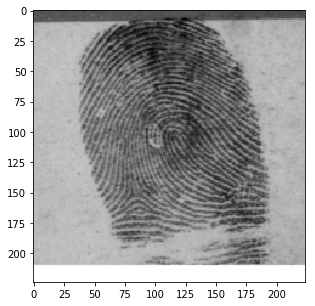

In [12]:
plt.figure(figsize=[5, 5])
curr_img = images_arr[3]
plt.imshow(curr_img, cmap='gray')
plt.show()

In [13]:
images_arr = images_arr.reshape(-1, 224,224, 1)

In [14]:
images_arr.shape

(4000, 224, 224, 1)

In [15]:
images_arr[0]

array([[[195.],
        [195.],
        [193.],
        ...,
        [191.],
        [191.],
        [195.]],

       [[195.],
        [193.],
        [192.],
        ...,
        [191.],
        [194.],
        [194.]],

       [[193.],
        [194.],
        [192.],
        ...,
        [189.],
        [193.],
        [191.]],

       ...,

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]],

       [[255.],
        [255.],
        [255.],
        ...,
        [255.],
        [255.],
        [255.]]], dtype=float32)

In [16]:
images_arr = images_arr / np.max(images_arr)
images_arr[0]

array([[[0.7647059 ],
        [0.7647059 ],
        [0.75686276],
        ...,
        [0.7490196 ],
        [0.7490196 ],
        [0.7647059 ]],

       [[0.7647059 ],
        [0.75686276],
        [0.7529412 ],
        ...,
        [0.7490196 ],
        [0.7607843 ],
        [0.7607843 ]],

       [[0.75686276],
        [0.7607843 ],
        [0.7529412 ],
        ...,
        [0.7411765 ],
        [0.75686276],
        [0.7490196 ]],

       ...,

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]],

       [[1.        ],
        [1.        ],
        [1.        ],
        ...,
        [1.        ],
        [1.        ],
        [1.        ]]], dtype=float32)

In [17]:
train_X,valid_X,train_ground,valid_ground = train_test_split(images_arr,
                                                             images_arr,
                                                             test_size=0.2,
                                                             random_state=1)

In [18]:
batch_size = 8
epochs = 50
Channel = 1
x, y = 224, 224
input_img = Input(shape = (x, y, Channel))

In [19]:
def autoencoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [20]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [21]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 128)       147584    
__________

In [24]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Train on 3200 samples, validate on 800 samples
Epoch 1/50
  64/3200 [..............................] - ETA: 31:27 - loss: 0.0165

KeyboardInterrupt: 